### Step 1: Import and Install Dependencies

In [31]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp


### Step 2: Keypoints using MP Holistic

In [32]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [33]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR-CONVERSION BGR-to-RGB
    image.flags.writeable = False                  # Convert image to not-writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Convert image to writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR-COVERSION RGB-to-BGR
    return image, results

In [34]:
def draw_landmarks(image, results):
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION,
                                mp_drawing.DrawingSpec(color=(80, 110, 10), thickness=1, circle_radius=1),
                                mp_drawing.DrawingSpec(color=(80, 256, 121), thickness=1, circle_radius=1)
                                ) 
    
    # Draw pose connections 
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                                mp_drawing.DrawingSpec(color=(80, 22, 10), thickness=2, circle_radius=4),
                                mp_drawing.DrawingSpec(color=(80, 44, 121), thickness=2, circle_radius=2)
                                )

    # Draw left hand connections 
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                                mp_drawing.DrawingSpec(color=(121, 22, 76), thickness=2, circle_radius=4),
                                mp_drawing.DrawingSpec(color=(121, 44, 250), thickness=2, circle_radius=2)
                                ) 

    # Draw right hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                                mp_drawing.DrawingSpec(color=(245, 117, 66), thickness=2, circle_radius=4),
                                mp_drawing.DrawingSpec(color=(245, 66, 230), thickness=2, circle_radius=2)
                                ) 

In [9]:
cap = cv2.VideoCapture(0)

# Set mediapipe model
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        # Read feed
        ret, frame = cap.read()

        # Flip the frame horizontally
        # flipped_frame = cv2.flip(frame, 1)

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_landmarks(image, results)

        # Show to screen
        cv2.imshow('FluentHands Feed', image)

        # Break Gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

In [10]:
draw_landmarks(frame, results)

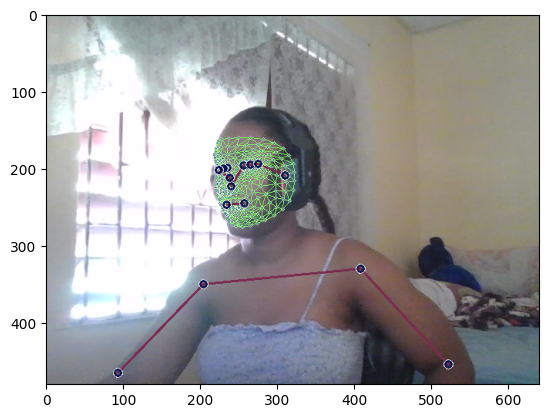

In [11]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

### Step 3: Extract Keypoint Values

In [12]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

In [19]:
result_test = extract_keypoints(results)
len(result_test)

1662

In [14]:
np.save('0', result_test)
np.load('0.npy')

array([ 0.37593669,  0.46475208, -0.60435158, ...,  0.        ,
        0.        ,  0.        ])

### Step 4: Setup Folders for Collection

In [23]:
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('MP_Data') 

# Actions that we try to detect
actions = np.array(['A', 'J', 'Z'])

# Thirty videos worth of data
no_sequences = 30

# Videos are going to be 30 frames in length
sequence_length = 30

# Folder start
# start_folder = 30

In [ ]:
# A
# - 0 (30 diff values)
# - 1
# ... 
# - 29

# J
# - 0 (30 diff values)
# - 1
# ... 
# - 29

# Z
# - 0 (30 diff values)
# - 1
# ... 
# - 29

In [ ]:
for action in actions:
    for sequence in range(no_sequences):
        try:
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass

### Step 5: Collect Keypoint Values for Training and Testing

In [ ]:
cap = cv2.VideoCapture(0)

# Set mediapipe model
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    # Loop through actions
    for action in actions:
        # Loop through sequences aka videos
        for sequence in range(no_sequences):
            # Loop through video length aka sequence length
            for frame_num in range(sequence_length):

                # Read feed
                ret, frame = cap.read()

                # Make detections
                image, results = mediapipe_detection(frame, holistic)
                print(results)
                
                # Draw landmarks
                draw_landmarks(image, results)

                # Wait Logic
                if frame_num == 0: 
                    cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                                cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    # cv2.imshow('FluentHands Feed', image)
                    cv2.waitKey(500) #i wanna make this longer
                else: 
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                
                # Export Keypoints
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

                # Show to screen
                cv2.imshow('FluentHands Feed', image)

                # Break Gracefully
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break

    cap.release()
    cv2.destroyAllWindows()

### Step 6: Preprocess Data and Create Labels and Features

In [35]:
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [36]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [37]:
label_map = {label:num for num, label in enumerate(actions)}
label_map

{'A': 0, 'J': 1, 'Z': 2}

In [38]:
sequences, labels = [], []

for action in actions:
    for sequence in range(no_sequences):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])
    # for sequence in np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int):
    #     window = []
    #     for frame_num in range(sequence_length):
    #         res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
    #         window.append(res)
    #     sequences.append(window)
    #     labels.append(label_map[action])

In [40]:
np.array(sequences).shape

(90, 30, 1662)

In [41]:
np.array(labels).shape

(90,)

In [42]:
X = np.array(sequences)

In [43]:
X.shape

(90, 30, 1662)

In [44]:
y = to_categorical(labels).astype(int)
y

array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0,

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

In [50]:
y_train.shape

(85, 3)

In [55]:
len(X_test)

5

### Step 7: Build and Train LSTM Neural Network

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard

In [25]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [45]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30, 1662)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [46]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [ ]:
model.fit(X_train, y_train, epochs=2000, callbacks=[tb_callback])

In [47]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 30, 64)            442112    
                                                                 
 lstm_7 (LSTM)               (None, 30, 128)           98816     
                                                                 
 lstm_8 (LSTM)               (None, 64)                49408     
                                                                 
 dense_5 (Dense)             (None, 64)                4160      
                                                                 
 dense_6 (Dense)             (None, 32)                2080      
                                                                 
 dense_7 (Dense)             (None, 3)                 99        
                                                                 
Total params: 596675 (2.28 MB)
Trainable params: 59667

### Step 8: Make Predictions

In [51]:
res = model.predict(X_test)

1/1 [==============================] - 0s 378ms/step


In [52]:
actions[np.argmax(res[4])]

'Z'

In [53]:
actions[np.argmax(y_test[4])]

'J'

### Step 9: Save Weights

In [28]:
import pickle
pickle.dump(model, open('model.pkl', 'wb'))

In [24]:
model.save('action.json')

INFO:tensorflow:Assets written to: action.json\assets


INFO:tensorflow:Assets written to: action.json\assets


In [58]:
model.load_weights('action.h5')

### Step 10: Evaluation using Confusion Matrix and Accuracy

In [59]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [60]:
yhat = model.predict(X_test)

1/1 [==============================] - 0s 34ms/step


In [61]:

ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [62]:
yhat

[1, 2, 0, 0, 1]

In [63]:
ytrue

[1, 2, 0, 0, 1]

In [64]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[3, 0],
        [0, 2]],

       [[3, 0],
        [0, 2]],

       [[4, 0],
        [0, 1]]], dtype=int64)

In [65]:
accuracy_score(ytrue, yhat)

1.0

### Step 11: Test in Real Time

In [66]:
colors = [(245,117,16), (117,245,16), (16,117,245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

In [69]:
# 1. New detection variables
sequence = []
sentence = []
predictions = []
threshold = 0.7

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        # print(results)
        
        # Draw landmarks
        draw_landmarks(image, results)
        
        # Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print('sequence: ', sequence)
            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))
            
            
            # Visualization logic
            if np.unique(predictions[-10:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold: 
                    
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Visualization probabilities
            image = prob_viz(res, actions, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('FluentHands Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
        
    cap.release()
    cv2.destroyAllWindows()

1/1 [==============================] - 0s 21ms/step
sequence:  [array([ 0.36240923,  0.52077562, -0.4258253 , ...,  0.        ,
        0.        ,  0.        ]), array([ 0.36433989,  0.52063292, -0.43038526, ...,  0.        ,
        0.        ,  0.        ]), array([ 0.36447501,  0.52016121, -0.462257  , ...,  0.        ,
        0.        ,  0.        ]), array([ 0.36444855,  0.51970035, -0.45560956, ...,  0.        ,
        0.        ,  0.        ]), array([ 0.3643696 ,  0.51972729, -0.45455709, ...,  0.        ,
        0.        ,  0.        ]), array([ 0.36328736,  0.51926601, -0.42255038, ...,  0.        ,
        0.        ,  0.        ]), array([ 0.36221632,  0.51927084, -0.3987911 , ...,  0.        ,
        0.        ,  0.        ]), array([ 0.3616268 ,  0.51930088, -0.4010517 , ...,  0.        ,
        0.        ,  0.        ]), array([ 0.36164808,  0.51919568, -0.40073276, ...,  0.        ,
        0.        ,  0.        ]), array([ 0.36173448,  0.51915973, -0.41571426,

In [ ]:
# Emergency Camera Release
cap.release()
cv2.destroyAllWindows()